In [1]:
# Imports e carregamento da base de dados

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Carregar base
df = pd.read_csv('../data/raw/clientes.csv')

# Selecionar colunas para clusterização
features = [
    'renda_mensal', 'ticket_medio',
    'qtd_compras_ultimos_12m', 'tempo_como_cliente',
    'visitas_site_mes', 'satisfacao'
]

X = df[features].copy()

In [3]:
# Padronizar os dados

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

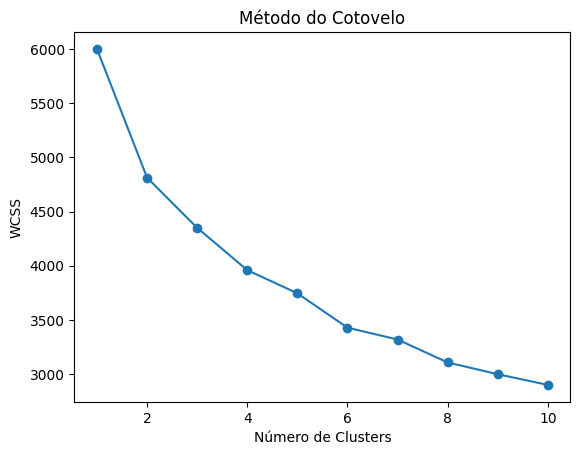

In [4]:
# Definir número ideal de clusters (Método do cotovelo)

wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.title('Método do Cotovelo')
plt.show()

# Escolha o ponto onde a queda do WCSS começa a diminuir (cotovelo). Normalmente entre 3 e 5

In [5]:
# Rodar KMeans com o número de clusters escolhido

kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

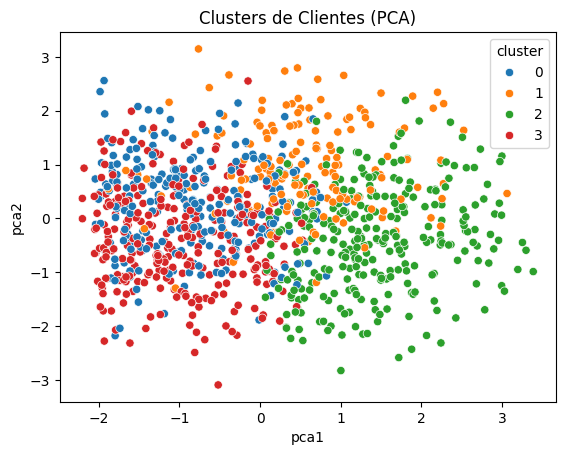

In [6]:
# Visualizar os clusters com PCA (redução de dimensionalidade)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='tab10')
plt.title('Clusters de Clientes (PCA)')
plt.show()


In [7]:
# Análise dos perfis dos clusters

df.groupby('cluster')[features].mean().round(1)


,renda_mensal,ticket_medio,qtd_compras_ultimos_12m,tempo_como_cliente,visitas_site_mes,satisfacao
cluster,,,,,,
0,4291.6,290.7,7.8,19.5,22.6,3.5
1,4787.9,354.3,19.7,38.2,15.5,1.7
2,4794.2,301.9,30.1,47.3,13.3,4.0
3,5883.5,313.6,6.6,18.7,7.8,3.6


In [8]:

# Análise de churn por cluster

df.groupby('cluster')[features + ['churn']].mean().round(2)


,renda_mensal,ticket_medio,qtd_compras_ultimos_12m,tempo_como_cliente,visitas_site_mes,satisfacao,churn
cluster,,,,,,,
0,4291.58,290.68,7.84,19.48,22.63,3.53,0.15
1,4787.92,354.25,19.75,38.22,15.45,1.71,0.43
2,4794.18,301.89,30.11,47.27,13.30,3.98,0.08
3,5883.48,313.64,6.58,18.71,7.76,3.63,0.13


In [9]:
# Verificar se os grupos estão balanceados ou se há dominação de algum grupo

df['cluster'].value_counts().sort_index()

cluster
0    262
1    166
2    285
3    287
Name: count, dtype: int64

In [10]:
# Verificar quais grupos tem mais risco de evasão

df.groupby('cluster')['churn'].mean().round(3)

cluster
0    0.153
1    0.434
2    0.081
3    0.132
Name: churn, dtype: float64

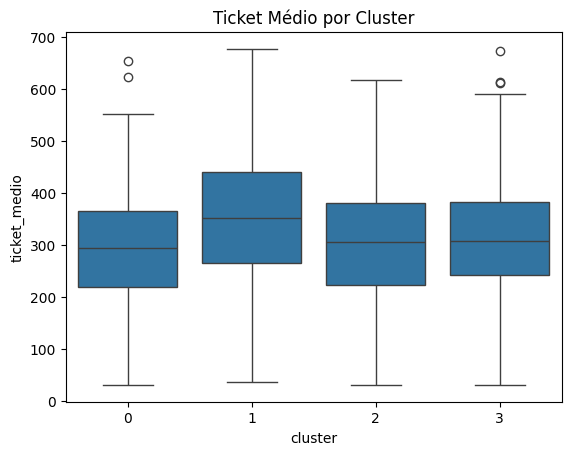

In [11]:
# Ticket médio vs Churn

sns.boxplot(x='cluster', y='ticket_medio', data=df)
plt.title('Ticket Médio por Cluster')
plt.show()


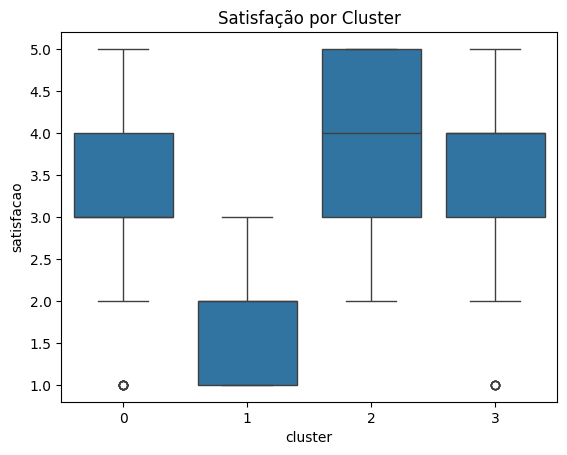

In [12]:
# Satisfação por cluster

sns.boxplot(x='cluster', y='satisfacao', data=df)
plt.title('Satisfação por Cluster')
plt.show()

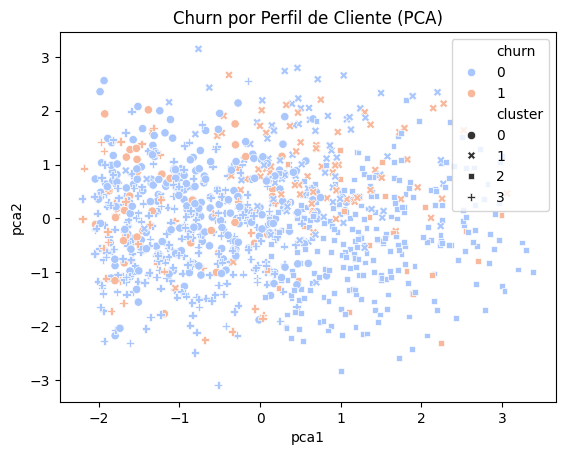

In [13]:
# Composição dos clusters em 2D (colorido por churn)

sns.scatterplot(data=df, x='pca1', y='pca2', hue='churn', style='cluster', palette='coolwarm')
plt.title('Churn por Perfil de Cliente (PCA)')
plt.show()

In [14]:
# Função para nomear os clusters

def nomear_clusters(df, mapping=None):
    """
    Adiciona uma coluna 'perfil_cliente' ao DataFrame com base no cluster.

    Parâmetros:
        df: DataFrame com a coluna 'cluster'
        mapping: dicionário opcional de mapeamento {cluster: nome}

    Retorna:
        df com nova coluna 'perfil_cliente'
    """
    if mapping is None:
        # Mapping de exemplo — ajuste conforme seu caso real
        mapping = {
            0: 'Clientes Premium',
            1: 'Clientes em Risco',
            2: 'Novatos em Potencial',
            3: 'Alto Valor, Baixo Engajamento'
        }

    df['perfil_cliente'] = df['cluster'].map(mapping)
    return df

In [15]:
df = nomear_clusters(df)

# Ver os perfis
df[['cluster', 'perfil_cliente']].drop_duplicates()


,cluster,perfil_cliente
0,3,"Alto Valor, Baixo Engajamento"
1,2,Novatos em Potencial
3,1,Clientes em Risco
4,0,Clientes Premium


In [16]:
df.to_csv('../data/processed/clientes_com_perfil.csv', index=False)

# Exportar o DataFrame com os clusters nomeados

In [17]:
# Atualizando mapeamento dos clusters

mapping = {
    0: 'Engajados e Estáveis',
    1: 'Clientes Exigentes e em Risco',
    2: 'Clientes Leais',
    3: 'Clientes de Alto Potencial'
}

df['perfil_cliente'] = df['cluster'].map(mapping)